In [1]:
import altair as alt
import pandas as pd
alt.renderers.enable('mimetype')
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

In [2]:
pop = pd.read_csv('data/raw/API_SP.POP.TOTL_DS2_en_csv_v2_1678576.csv', skiprows=4).drop(
    columns=['Country Code', 'Indicator Name', 'Indicator Code', '2020', 'Unnamed: 65']).melt(id_vars=['Country Name'],
                                                                                              var_name='Year',
                                                                                              value_name='Population')
pop = pop.rename(columns={'Country Name': 'Country'})
pop["Country"] = pop["Country"].replace("West Bank and Gaza", 'Palestine')
pop

,Country,Year,Population
0,Aruba,1960,54211.0
1,Afghanistan,1960,8996973.0
2,Angola,1960,5454933.0
3,Albania,1960,1608800.0
4,Andorra,1960,13411.0
...,...,...,...
15835,Kosovo,2019,1794248.0
15836,"Yemen, Rep.",2019,29161922.0
15837,South Africa,2019,58558270.0
15838,Zambia,2019,17861030.0


In [3]:
crops = pd.read_csv('data/raw/Production_Crops_E_Asia_NOFLAG.csv')

In [4]:
paddy_wheat = crops.loc[(crops['Item Code'].isin(['15', '27', '30'])) & (crops['Element Code'] == 5510)].drop(
    columns=['Element Code', 'Element', 'Unit', 'Item Code', 'Area Code'])

In [5]:
paddy_wheat_melt = paddy_wheat.melt(id_vars=['Area', 'Item'],
                                    var_name='Year',
                                    value_name='Tonnes of crop').dropna()
paddy_wheat_melt['Year'] = paddy_wheat_melt['Year'].str.replace('Y','')
replace_countries = {'Viet Nam': 'Vietnam',
                     'Yemen': 'Yemen, Rep.',
                     'China, Hong Kong SAR': 'China',
                     'China, Taiwan Province of': 'China',
                     'China, mainland': 'China',
                     'Republic of Korea': 'Korea, Rep.',
                     'Democratic People\'s Republic of Korea': 'Korea, Dem. People’s Rep.',
                     'Iran (Islamic Republic of)': 'Iran, Islamic Rep.',
                     'Kyrgyzstan': 'Kyrgyz Republic',
                     'Lao People\'s Democratic Republic': 'Lao PDR'}
paddy_wheat_melt = paddy_wheat_melt.replace({"Area": replace_countries})

In [6]:
paddy_wheat_table = paddy_wheat_melt.pivot_table(values=['Tonnes of crop'], index=['Area', 'Year'], columns=['Item']).reset_index()
paddy_wheat_table.columns = ['Country', 'Year', 'Paddy_1', 'Paddy_2', 'Wheat']
paddy_wheat_table['Paddy'] = paddy_wheat_table['Paddy_1'] + paddy_wheat_table['Paddy_2']
paddy_wheat_table = paddy_wheat_table.drop(columns = ['Paddy_1', 'Paddy_2'])

In [7]:
final_df = pd.merge(paddy_wheat_table, pop, how="left", on=["Country", "Year"])
final_df

,Country,Year,Wheat,Paddy,Population
0,Afghanistan,1961,2279000.0,531773.0,9169410.0
1,Afghanistan,1962,2279000.0,531773.0,9351441.0
2,Afghanistan,1963,1947000.0,531773.0,9543205.0
3,Afghanistan,1964,2230000.0,633460.0,9744781.0
4,Afghanistan,1965,2282000.0,633460.0,9956320.0
...,...,...,...,...,...
2264,"Yemen, Rep.",2014,192215.0,NaN,25823485.0
2265,"Yemen, Rep.",2015,124940.0,NaN,26497889.0
2266,"Yemen, Rep.",2016,95917.0,NaN,27168210.0
2267,"Yemen, Rep.",2017,95651.0,NaN,27834821.0


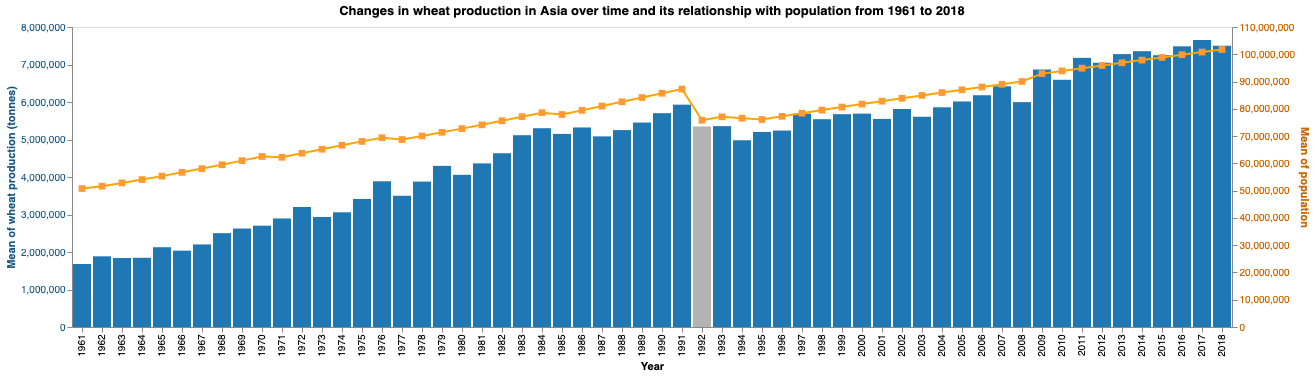

In [8]:
# Wheat production plot
wheat_plot = alt.Chart(final_df, title='Changes in wheat production in Asia over time and its relationship with population from 1961 to 2018') \
                .mark_bar().encode(
    x='Year',
    y = alt.Y('mean(Wheat)', title='Mean of wheat production (tonnes)',
             axis=alt.Axis(titleColor='#165683')),
    color=alt.condition(
        alt.datum.Year == '1992', # highlight the year when wheat production and population decreased markedly
        alt.value('#b3b3b3'),
        alt.value('#1f77b4')))

# Population plot
pop_plot = alt.Chart(final_df).mark_line(color = 'orange').encode(
    x='Year',
    y = alt.Y('mean(Population)', title='Mean of population',
             axis=alt.Axis(titleColor='#cc6600')))

pop_plot = pop_plot + pop_plot.mark_square(color = '#ff9933', size = 45)
plot = wheat_plot + pop_plot
plot

alt.layer(wheat_plot, pop_plot).resolve_scale(
    y = 'independent').configure_axisLeft(labelColor='#165683').configure_axisRight(labelColor='#cc6600')

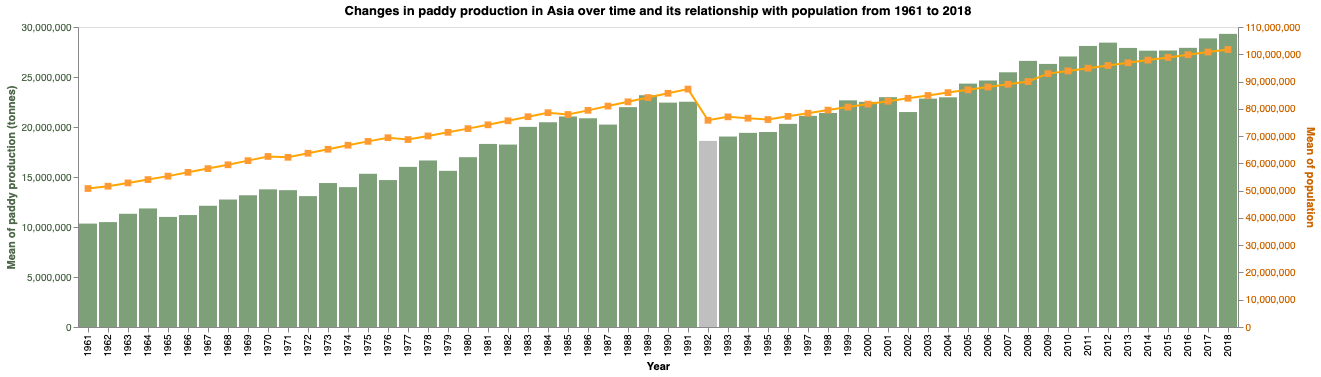

In [9]:
# Paddy production plot
wheat_plot= alt.Chart(final_df, title='Changes in paddy production in Asia over time and its relationship with population from 1961 to 2018') \
               .mark_bar().encode(
    x='Year',
    y = alt.Y('mean(Paddy)', title='Mean of paddy production (tonnes)',
             axis=alt.Axis(titleColor='#4e684a')),
    color=alt.condition(
        alt.datum.Year == '1992', # highlight the year when paddy production and population decreased markedly
        alt.value('#bfbfbf'),
        alt.value('#7da079')))

# Population plot
pop_plot = alt.Chart(final_df).mark_line(color = 'orange').encode(
    x='Year',
    y = alt.Y('mean(Population)', title='Mean of population',
             axis=alt.Axis(titleColor='#cc6600')))
pop_plot = pop_plot + pop_plot.mark_square(color = '#ff9933', size = 45)

plot = wheat_plot + pop_plot
plot

alt.layer(wheat_plot, pop_plot).resolve_scale(
    y = 'independent').configure_axisLeft(labelColor='#4e684a').configure_axisRight(labelColor='#cc6600')